## **Business Understanding**

Predicting sales is crucial for business planning. In this project, we'll use machine learning to build a model that forecasts store sales. We'll use data from Corporation Favorita, a leading grocery retailer in Ecuador.

### **Project Objective** 

Our main goal is to create a Machine Learning Model that predicts unit sales for various items sold in Favorita stores.

We'll analyze sales trends over time to understand customer behavior, identify seasonal patterns, and recognize other factors affecting sales. Factors like oil prices, holidays, and promotions can impact sales at Favorita. By analyzing this data, we aim to provide valuable insights to grocery retailers about customer preferences and behavior.

Further, by examining data on customer purchases, demographics, and social media activity, retailers can better understand what drives their customers. This information can help tailor marketing strategies to boost sales. Additionally, it can help identify slow-selling products, optimize inventory, reduce costs, and increase profits—especially for perishable items like dairy and meat.

We'll also look into improving checkout processes to enhance the shopping experience.

In summary, accurate sales forecasting helps businesses plan better, manage inventory efficiently, and make informed decisions. This precision enables companies like Favorita to reduce costs and increase profitability.

### **Project Approach and Methodology**

This project will adhere to the CRISP-DM (Cross-Industry Standard Process for Data Mining) Framework, a widely recognized methodology for data science projects. We will explore various machine learning techniques to achieve accurate sales predictions, including but not limited to:

1. **Time Series Forecasting**

Employing ARIMA, SARIMA, or LSTM to detect sales trends and seasonal variations.

2. **Regression Models**

Utilizing linear regression, decision trees, random forests, or gradient boosting to evaluate factors such as promotions, product attributes, and store specifics.

### **Hypothesis Testing**
H0(Null Hypothesis) - Promotion Activities have no significant effect on sales

H1(Alternative Hypothesis) - Promotion activities have a significant effect on sales

### **Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## **Data Understanding**

#### **Importations**

In [20]:
# Environment Setup
import dotenv
from dotenv import dotenv_values

# Data Handling
import pyodbc
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Analysis
import scipy
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

# Utility and Miscellaneous
import warnings
warnings.filterwarnings("ignore")
import zipfile
import os
import requests 
import joblib

In [10]:
# Load .env values
environment_variables = dotenv_values(r"C:\Users\Admin\OneDrive\OneDrive-Azubi\Time_Serries_Corp.Favourita\Time-Series-Regression-Analysis-Corporation-Favorita-\.env")

# Get .env values
server =  environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [11]:
# Connect to the database
connection = pyodbc.connect(connection_string)

 **Oil_data**

In [12]:
# Get data from table dbo.oil in the database
query_dbo_oil = "SELECT * FROM dbo.oil"
oil_data = pd.read_sql(query_dbo_oil, connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997



-Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and changes in prices affects the economy of the country with a ripple effect on sales such as corporate favorita)

-The term "dcoilwtico" refers to the daily crude oil price for West Texas Intermediate (WTI) crude oil

In [37]:
# Describe the oil data numerical values
oil_data.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190001
25%,46.405001
50%,53.189999
75%,95.660000
max,110.620003


In [38]:
# Describe oil data categorical values
oil_data.describe(include='object')

,date
count,1218
unique,1218
top,2017-08-31
freq,1


In [39]:
# Check for null values in the oil data 
print(f"Oil data null values: \n{oil_data.isnull().sum()}")

Oil data null values: 
date           0
dcoilwtico    43
dtype: int64


In [40]:
# Check for duplicates in the oil data
print(f"Oil data duplicates: \n{oil_data.duplicated().sum()}")

Oil data duplicates: 
0


In [41]:
# Check information for oil data
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [42]:
# copying oil data for plotting
oil_data_cp=oil_data.copy()

oil_data_cp
# Converting 'date' to datetime format
oil_data_cp['date'] = pd.to_datetime(oil_data_cp['date'])
# Settting 'date' as the index
oil_data_cp.set_index('date', inplace=True)

# Grouping the data by year and summing the 'dcoilwtico' values
grouped_data = oil_data_cp.resample('Y')['dcoilwtico'].mean()

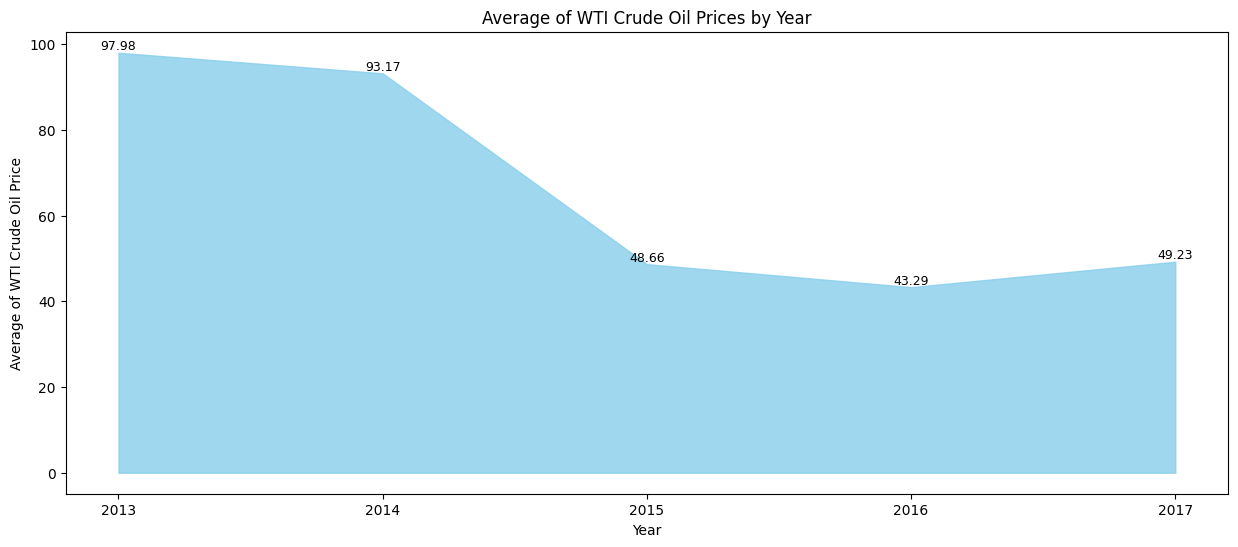

In [43]:
# Plotting area chart 
plt.figure(figsize=(15, 6))
plt.fill_between(grouped_data.index.year, grouped_data.values, color='skyblue', alpha=0.8)

# Adding data labels
for i, value in enumerate(grouped_data.values):
    plt.text(grouped_data.index.year[i], value, str(round(value, 2)), ha='center', va='bottom', fontsize=9)

plt.xticks(grouped_data.index.year)
plt.xlabel('Year')
plt.ylabel('Average of WTI Crude Oil Price')
plt.title('Average of WTI Crude Oil Prices by Year')
plt.show()

- Key Insights- oil data

-There are 43 missing values in oild data. Partcularaly the dcoilwtico column

-The date column is an object insted of datetime

**Holidays_events_data**

-Holidays and Events, with metadata NB: Take a keen look at the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. 

-A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

-Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [13]:
# Load data from dbo.holidays_events table in the database
query_dbo_holidays_events = "SELECT * FROM dbo.holidays_events"
holidays_events_data = pd.read_sql(query_dbo_holidays_events, connection)
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [44]:
# Get info of the holiday events database
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [45]:
# Check for null values in the holiday events data
holidays_events_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [46]:
# Check for duplicates in the holiday events data
holidays_events_data.duplicated().sum()

np.int64(0)

In [47]:
# Unique holiday events
holidays_events_data['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [48]:
# Unique holiday types
holidays_events_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [49]:
# Unique locale names
holidays_events_data['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

- Key insights- Holidays_events

-The date column is an object instead of datetime

-Change tranfered column from bool to object/category

-There are no null values

-There are no duplicates

**Stores_data**

-Store metadata, including city, state, type, and cluster.

-cluster is a grouping of similar stores.

In [14]:
# Load data from dbo.stores table in the database
query_dbo_stores = "SELECT * FROM dbo.stores"
stores_data = pd.read_sql(query_dbo_stores, connection)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [50]:
# Get info of the stores dataset
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [51]:
# Get all unique store numbers
stores_data['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [52]:
# Get all unique cities 
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [53]:
# Get all unique clusters
stores_data['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17])

In [54]:
# Get all unique type of stores
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [55]:
# Check for duplicates
stores_data.duplicated().sum()

np.int64(0)

In [56]:
# Check for null values
stores_data.isna().sum()   

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [23]:
# URL of the file to download
url = "https://github.com/Njuraita/Career_Accelerator_LP3-Regression/raw/main/store-sales-forecasting.zip"
 
# Local file path where the file will be saved
local_file_path = '../data/store-sales-forecasting.zip'
 
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
 
# Send a GET request to the URL
response = requests.get(url)
 
# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content of the response to the specified file path
    with open(local_file_path, "wb") as f:
        f.write(response.content)
    print("File downloaded successfully")
   
    # Extract the ZIP file
    with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(local_file_path))
    print("File extracted successfully")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully
File extracted successfully


In [27]:
# Read the downloaded CSV file into a DataFrame
df_train = pd.read_csv('../data/train.csv')
 
# Display the DataFrame
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [28]:
# Read the downloaded CSV file into a DataFrame
df_transactions = pd.read_csv('../data/transactions.csv')
 
# Display the DataFrame
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [29]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_data with stores_df based on 'store_nbr' 
columnmerged_df1 = pd.merge(df_train,stores_data, on='store_nbr', how='left')
columnmerged_df1.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [30]:
# Merge merged_df1 with trans_data based on 'date' and 'store_nbr' 
columnmerged_df2 = columnmerged_df1.merge(df_transactions, on=['date', 'store_nbr'], how='inner')
columnmerged_df2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770


In [31]:
# Merge merged_df2 with df_oil on 'date' 
columnmerged_df3 = columnmerged_df2.merge(oil_data, on='date', how='left')
columnmerged_df3.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,NaN
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,NaN
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,NaN
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,NaN
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,NaN


In [33]:
# Merge merged_df3 with df_holidays based on 'date' 
train_data= columnmerged_df3.merge(holidays_events_data, on='date', how='inner') 

train_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [34]:
train_data.shape

(459063, 17)

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459063 entries, 0 to 459062
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            459063 non-null  int64  
 1   date          459063 non-null  object 
 2   store_nbr     459063 non-null  int64  
 3   family        459063 non-null  object 
 4   sales         459063 non-null  float64
 5   onpromotion   459063 non-null  int64  
 6   city          459063 non-null  object 
 7   state         459063 non-null  object 
 8   type_x        459063 non-null  object 
 9   cluster       459063 non-null  int64  
 10  transactions  459063 non-null  int64  
 11  dcoilwtico    300003 non-null  float64
 12  type_y        459063 non-null  object 
 13  locale        459063 non-null  object 
 14  locale_name   459063 non-null  object 
 15  description   459063 non-null  object 
 16  transferred   459063 non-null  bool   
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [36]:
train_data.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
transactions         0
dcoilwtico      159060
type_y               0
locale               0
locale_name          0
description          0
transferred          0
dtype: int64